In [17]:


%matplotlib notebook

import datetime

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import pandas as pd

from pandas.plotting import register_matplotlib_converters 

import utide

print(utide.__version__)



0.2.5


In [18]:
with open('can1998.tdf') as f:
    lines = f.readlines()
print(''.join(lines[:30]))

         0 1998  1  1  0.0000     1.200 0
      3600 1998  1  1  1.0000     1.430 0
      7200 1998  1  1  2.0000     1.730 0
     10800 1998  1  1  3.0000     2.030 0
     14400 1998  1  1  4.0000     2.380 0
     18000 1998  1  1  5.0000     2.540 0
     21600 1998  1  1  6.0000     2.460 0
     25200 1998  1  1  7.0000     2.270 0
     28800 1998  1  1  8.0000     1.980 0
     32400 1998  1  1  9.0000     1.670 0
     36000 1998  1  1 10.0000     1.550 0
     39600 1998  1  1 11.0000     1.630 0
     43200 1998  1  1 12.0000     1.810 0
     46800 1998  1  1 13.0000     1.980 0
     50400 1998  1  1 14.0000     2.010 0
     54000 1998  1  1 15.0000     1.980 0
     57600 1998  1  1 16.0000     2.130 0
     61200 1998  1  1 17.0000     2.280 0
     64800 1998  1  1 18.0000     2.330 0
     68400 1998  1  1 19.0000     2.280 0
     72000 1998  1  1 20.0000     1.930 0
     75600 1998  1  1 21.0000     1.650 0
     79200 1998  1  1 22.0000     1.380 0
     82800 1998  1  1 23.0000     

In [19]:
def date_parser(year, month, day, hour):
    year, month, day, hour = map(int, (year, month, day, hour))
    return datetime.datetime(year, month, day, hour)

# Names of the columns that will be used to make a "datetime" column:
parse_dates = dict(datetime=['year', 'month', 'day','hour'])

# Names of the original columns in the file, including only
# the ones we will use; we are skipping the first, which appears
# to be seconds from the beginning.
names = ['year', 'month', 'day', 'hour', 'elev', 'flag']

obs = pd.read_table('can1998.tdf',
                    names=names,
                    skipinitialspace=True,
                    delim_whitespace=True,
                    index_col='datetime',
                    usecols=range(1, 7),
                    na_values='9.990',
                    parse_dates=parse_dates,
                    date_parser=date_parser,
                   )
obs.head(6)

,elev,flag
datetime,,
1998-01-01 00:00:00,1.20,0
1998-01-01 01:00:00,1.43,0
1998-01-01 02:00:00,1.73,0
1998-01-01 03:00:00,2.03,0
1998-01-01 04:00:00,2.38,0
1998-01-01 05:00:00,2.54,0


In [20]:
bad = obs['flag'] == 2
corrected = obs['flag'] == 1

obs.loc[bad, 'elev'] = np.nan
obs['anomaly'] = obs['elev'] - obs['elev'].mean()
obs['anomaly'] = obs['anomaly'].interpolate()
print('{} points were flagged "bad" and interpolated'.format(bad.sum()))
print('{} points were flagged "corrected" and left unchanged'.format(corrected.sum()))

10 points were flagged "bad" and interpolated
212 points were flagged "corrected" and left unchanged


In [21]:


time = mdates.date2num(obs.index.to_pydatetime())

coef = utide.solve(time, obs['anomaly'].values,
                   lat=-25,
                   method='ols',
                   conf_int='MC')



solve: matrix prep ... solution ... diagnostics ... done.


In [28]:
print(coef.keys())
print(coef)

dict_keys(['name', 'aux', 'nR', 'nNR', 'nI', 'weights', 'A', 'g', 'mean', 'slope', 'g_ci', 'A_ci', 'diagn'])
A       : [3.71220478e-01 2.42991812e-01 1.09297864e-01 7.73350128e-02
 6.77366585e-02 6.51779557e-02 6.37862484e-02 5.67144408e-02
 3.64668856e-02 3.24316707e-02 3.14847542e-02 3.11233442e-02
 2.74651335e-02 2.73697794e-02 2.65278834e-02 2.64884084e-02
 2.62671383e-02 2.58648599e-02 2.52725340e-02 2.26786092e-02
 1.98222403e-02 1.58818273e-02 1.33720232e-02 1.05771748e-02
 9.72959564e-03 9.51812745e-03 8.19192192e-03 7.24969099e-03
 6.92317214e-03 6.77220826e-03 6.11266445e-03 5.16968038e-03
 4.83224711e-03 4.81055489e-03 3.43796408e-03 3.19281780e-03
 3.19168992e-03 3.12285084e-03 3.11619748e-03 2.92108211e-03
 2.90354584e-03 2.89918123e-03 2.70040522e-03 2.53299528e-03
 2.26569813e-03 2.02602526e-03 1.81924596e-03 1.61571235e-03
 1.60763133e-03 1.51070964e-03 1.43566416e-03 1.43013412e-03
 1.14563805e-03 9.02565682e-04 8.72012450e-04 8.32881325e-04
 5.64913869e-04 5.38638406e

In [23]:
tide = utide.reconstruct(time, coef)

prep/calcs ... done.


In [27]:
print(tide.keys())
print(tide.constit)
tide.keys()

dict_keys(['t_in', 'epoch', 'constit', 'min_SNR', 'min_PE', 't_mpl', 'h'])
None


dict_keys(['t_in', 'epoch', 'constit', 'min_SNR', 'min_PE', 't_mpl', 'h'])

<IPython.core.display.Javascript object>


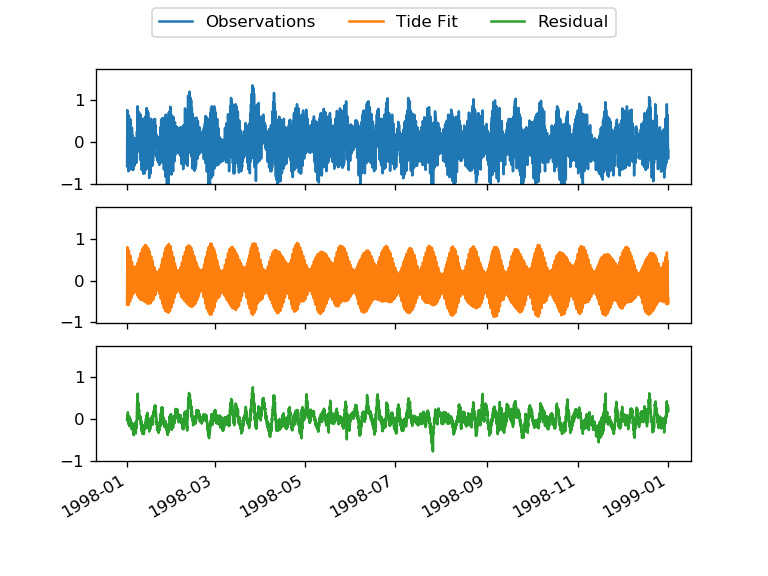

In [26]:
#t = obs.index.values  # dtype is '<M8[ns]' (numpy datetime64)
# It is more efficient to supply the time directly as matplotlib
# datenum floats:
t = tide.t_mpl

fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharey=True, sharex=True)

ax0.plot(t, obs.anomaly, label=u'Observations', color='C0')
ax1.plot(t, tide.h, label=u'Tide Fit', color='C1')
ax2.plot(t, obs.anomaly - tide.h, label=u'Residual', color='C2')
ax2.xaxis_date()
fig.legend(ncol=3, loc='upper center')
fig.autofmt_xdate()

In [ ]:
nobs = 3015 
ngood = 3015 
record length (days) = 125.62
rayleigh criterion = 1.0

Phases at central time
x0= 1.55  xtrend= 0
var(data)= 0.95    var(prediction)= 0.93    var(residual)= 0.02
var(prediction)/var(data) (%) = 97.7

        tidal amplitude and phase with 95 % CI estimates
 tide      freq        amp      amp_err   pha      pha_err    snr
  MM    0.0015122     0.0189     0.044     82.60    186.28      0.18
  MSF   0.0028219     0.0293     0.051    217.94    112.30      0.33
  ALP1  0.0343966     0.0027     0.009      5.20    131.27     0.082
  2Q1   0.0357064     0.0041     0.012     12.47     40.61      0.13
* Q1    0.0372185     0.0160     0.008     99.36     55.42       4.5
* O1    0.0387307     0.1122     0.001    125.02     10.96   1.1e+04
* NO1   0.0402686     0.0153     0.007    335.29     60.37       4.2
* K1    0.0417807     0.1472     0.000    310.48      6.53   9.2e+04
* J1    0.0432929     0.0116     0.007    310.35    107.03       2.9
  OO1   0.0448308     0.0086     0.009    351.76     85.52      0.99
  UPS1  0.0463430     0.0086     0.015    204.50     26.09      0.33
  EPS2  0.0761773     0.0051     0.015     87.78    163.52      0.12
  MU2   0.0776895     0.0205     0.019     81.28     50.32       1.2
* N2    0.0789992     0.3035     0.018    131.25      3.63   2.9e+02
* M2    0.0805114     1.2903     0.018    158.43      0.80   5.2e+03
* L2    0.0820236     0.0646     0.019     21.68     17.23        11
* S2    0.0833333     0.1938     0.018    281.66      5.78   1.1e+02
  ETA2  0.0850736     0.0029     0.013    199.55    225.29     0.053
* MO3   0.1192421     0.0044     0.002    223.94     18.55       7.9
* M3    0.1207671     0.0027     0.001     24.02     32.69       3.2
* MK3   0.1222921     0.0038     0.002     43.20     24.43       6.4
  SK3   0.1251141     0.0019     0.001    223.58     52.02       1.7
* MN4   0.1595106     0.0068     0.002     56.85     20.62        16
* M4    0.1610228     0.0159     0.002     70.99      7.05        53
  SN4   0.1623326     0.0018     0.002    254.49     57.15      0.91
* MS4   0.1638447     0.0046     0.002    210.01     23.10       4.9
  S4    0.1666667     0.0005     0.001    281.03    154.39      0.18
* 2MK5  0.2028035     0.0026     0.001    332.57     22.32         6
  2SK5  0.2084474     0.0012     0.001    307.54     50.94       1.4
* 2MN6  0.2400221     0.0061     0.002    279.24     17.17        12
* M6    0.2415342     0.0089     0.002    306.88     12.11        28
* 2MS6  0.2443561     0.0033     0.002     73.02     28.82       3.2
  2SM6  0.2471781     0.0007     0.001    227.33    148.22      0.25
  3MK7  0.2833149     0.0008     0.001    213.10     91.11      0.59
* M8    0.3220456     0.0019     0.001    147.31     37.54       2.9
0.2.5

Analyze the tide using t_tide

In [29]:
print(158.43 -105.92)
print(82.6 -105.92)
print(158.43 -105.92)
print(158.43 -105.92)
print(158.43 -92.96.92)

52.510000000000005


In [30]:
3014/24

125.58333333333333